In [1]:
# Paper or Website plots
PaperPlots = False # Paper and website have different formating. True for running for paper figures. False for running website plots.

In [2]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

'''
Plot forecast maps with all available models.
'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
if not PaperPlots:
    matplotlib.use('Agg')
import matplotlib.pyplot as plt
from collections import OrderedDict
import itertools
import numpy as np
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import json

from esio import EsioData as ed
from esio import ice_plot
from esio import import_data
from esio import metrics

import dask
import timeit
from dask.distributed import Client

# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=.8, rc={"lines.linewidth": 2.5})

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  F

In [3]:
#def Update_Evaluation_Maps(PaperPlots = False):

#     client = Client(n_workers=8)
#     client

# Domain options to use for calculating metrics over
customDomainName = 'ArcticSeas' 
# Options:
# 'ArcticSeas' will use the Arctic Seas domain shown in Supplemental information
# 'X' where X is a model name to use as the domain (i.e. X='rasmesrl' because it is the smallest domain)

### Code

metrics_all = ['anomaly','mean','SIP']
runType = 'forecast'
variables = ['sic']

# Only use 'sic' here
cvar = variables[0]

# Get path data
E = ed.EsioData.load()
grid_dir = E.grid_dir

# Load in regional data
ds_region = xr.open_dataset(os.path.join(grid_dir, 'sio_2016_mask_Update.nc'))

fig_dir = os.path.join('/home/disk/sipn/nicway/public_html/sipn/figures/model/Eval')

#redirect to my dir for now
fig_dir  = os.path.join('/home/disk/sipn/bitz/figures')
    
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    
# Load from Zarr
ds_m = xr.open_zarr(os.path.join(E.data_dir,'model/zarr',cvar+'.zarr'))

In [4]:
print(ds_m.model.values)
ds_ALL = ds_m.where(ds_m.model!=b'rasmesrl', drop=True)  # funny domain causes problems
ds_ALL = ds_m.where(ds_ALL.model!=b'climatology', drop=True)  # use climo10yrs instead
# # Drop models that we don't evaluate (i.e. monthly means)
ds_ALL = ds_m.where(ds_ALL.model!=b'szapirosipn', drop=True)
ds_ALL = ds_m.where(ds_ALL.model!=b'awispin', drop=True)
ds_ALL = ds_m.where(ds_ALL.model!=b'nicosipn', drop=True)
print(ds_ALL.model.values)


[b'MME' b'Observed' b'awispin' b'climatology' b'climo10yrs'
 b'dampedAnomalyTrend' b'ecmwf' b'ecmwfsipn' b'fgoalssipn' b'gfdlsipn'
 b'kma' b'meteofrsipn' b'metreofr' b'ncep' b'nicosipn' b'rasmesrl'
 b'szapirosipn' b'ukmetofficesipn' b'ukmo' b'usnavygofs' b'usnavyncep'
 b'usnavysipn' b'yopp']
[b'MME' b'Observed' b'climo10yrs' b'dampedAnomalyTrend' b'ecmwf'
 b'ecmwfsipn' b'fgoalssipn' b'gfdlsipn' b'kma' b'meteofrsipn' b'metreofr'
 b'ncep' b'ukmetofficesipn' b'ukmo' b'usnavygofs' b'usnavyncep'
 b'usnavysipn' b'yopp']


In [5]:
# Hack to decode strings
ds_ALL['model'] = [s.decode("utf-8") for s in ds_ALL.model.values]

# Order models to plot in
models_first = ['climo10yrs','dampedAnomalyTrend','MME']
X = list(ds_ALL.model.values)
[X.remove(a) for a in models_first]
model_plot_order = models_first + X
model_plot_order.remove('Observed')
print(model_plot_order)

# Get custom domain mask if we have defined it (i.e. not None)
if customDomainName=='ArcticSeas':
    customDomain = None
    fig_ext = '' # Figure extention to separte domain names
else:
    customDomain = ds_ALL.sel(model=customDomainName).isel(fore_time=0,init_end=40).SIP.notnull()
    # Drop coods
    customDomain = customDomain.drop(['fore_time','init_end','init_start','valid_end','valid_start','model'])
    if customDomain.sum().values==0:
        raise ValueError("Warning: you need to choose a fore_time and init_end that has model data represenative of its extent")
    fig_ext = customDomainName+'_' # Figure extention to separte domain names

['climo10yrs', 'dampedAnomalyTrend', 'MME', 'ecmwf', 'ecmwfsipn', 'fgoalssipn', 'gfdlsipn', 'kma', 'meteofrsipn', 'metreofr', 'ncep', 'ukmetofficesipn', 'ukmo', 'usnavygofs', 'usnavyncep', 'usnavysipn', 'yopp']


In [6]:
ds_m.init_end.values

array(['2018-01-07T00:00:00.000000000', '2018-01-14T00:00:00.000000000',
       '2018-01-21T00:00:00.000000000', '2018-01-28T00:00:00.000000000',
       '2018-02-04T00:00:00.000000000', '2018-02-11T00:00:00.000000000',
       '2018-02-18T00:00:00.000000000', '2018-02-25T00:00:00.000000000',
       '2018-03-04T00:00:00.000000000', '2018-03-11T00:00:00.000000000',
       '2018-03-18T00:00:00.000000000', '2018-03-25T00:00:00.000000000',
       '2018-04-01T00:00:00.000000000', '2018-04-08T00:00:00.000000000',
       '2018-04-15T00:00:00.000000000', '2018-04-22T00:00:00.000000000',
       '2018-04-29T00:00:00.000000000', '2018-05-06T00:00:00.000000000',
       '2018-05-13T00:00:00.000000000', '2018-05-20T00:00:00.000000000',
       '2018-05-27T00:00:00.000000000', '2018-06-03T00:00:00.000000000',
       '2018-06-10T00:00:00.000000000', '2018-06-17T00:00:00.000000000',
       '2018-06-24T00:00:00.000000000', '2018-07-01T00:00:00.000000000',
       '2018-07-08T00:00:00.000000000', '2018-07-15

In [7]:
# Calculate the IIEE (Integrated Ice Edge Error)
l = []
for cmod in model_plot_order: 
    c_SIP_IIEE = metrics.IIEE(da_mod=ds_ALL.sel(model=cmod)['mean'], 
                                      da_obs=ds_ALL.sel(model='Observed')['mean'], 
                                      region=ds_region, 
                                      testplots=False,
                                      customDomain=customDomain)
    c_SIP_IIEE.coords['model'] = cmod
    l.append(c_SIP_IIEE)
SIP_IIEE = xr.concat(l, dim='model')
SIP_IIEE

<xarray.DataArray (model: 17, init_end: 99, fore_time: 52)>
dask.array<shape=(17, 99, 52), dtype=float64, chunksize=(1, 4, 10)>
Coordinates:
    crs          object 'crs'
  * fore_time    (fore_time) timedelta64[ns] 0 days 7 days ... 350 days 357 days
  * init_end     (init_end) datetime64[ns] 2018-01-07 2018-01-14 ... 2019-11-24
    init_start   (init_end) datetime64[ns] 2018-01-01 2018-01-08 ... 2019-11-18
    valid_end    (init_end, fore_time) datetime64[ns] 2018-01-07 ... 2020-11-15
    valid_start  (init_end, fore_time) datetime64[ns] 2018-01-01 ... 2020-11-09
  * model        (model) <U18 'climo10yrs' 'dampedAnomalyTrend' ... 'yopp'

In [8]:
# For SIP, calculate the Brier Skill Score for panArctic 
# BS = (SIP_model - SIP_observed)^2
#
l = []
for cmod in model_plot_order: 
    c_SIP_BSS = metrics.BrierSkillScore(da_mod_sip=ds_ALL.sel(model=cmod).SIP, 
                                      da_obs_ip=ds_ALL.sel(model='Observed').SIP, 
                                      region=ds_region, 
                                      testplots=False,
                                      customDomain=customDomain)
    c_SIP_BSS.coords['model'] = cmod
    l.append(c_SIP_BSS)
SIP_BSS = xr.concat(l, dim='model')
SIP_BSS

<xarray.DataArray (model: 17, init_end: 99, fore_time: 52, y: 448, x: 304)>
dask.array<shape=(17, 99, 52, 448, 304), dtype=float64, chunksize=(1, 4, 10, 448, 304)>
Coordinates:
    crs          object 'crs'
  * fore_time    (fore_time) timedelta64[ns] 0 days 7 days ... 350 days 357 days
  * init_end     (init_end) datetime64[ns] 2018-01-07 2018-01-14 ... 2019-11-24
    init_start   (init_end) datetime64[ns] 2018-01-01 2018-01-08 ... 2019-11-18
    lat          (x, y) float64 31.1 31.25 31.4 31.55 ... 34.77 34.62 34.47
    lon          (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    valid_end    (init_end, fore_time) datetime64[ns] 2018-01-07 ... 2020-11-15
    valid_start  (init_end, fore_time) datetime64[ns] 2018-01-01 ... 2020-11-09
  * x            (x) int64 0 1 2 3 4 5 6 7 8 ... 296 297 298 299 300 301 302 303
  * y            (y) int64 0 1 2 3 4 5 6 7 8 ... 440 441 442 443 444 445 446 447
    hole_mask    (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 

In [9]:
# this is slow maybe 5 min
# Aggregate over space (x,y), including all pixels in valid Arctic seas (masked above with BrierSkillScore())
BSS_agg = SIP_BSS.mean(dim=['x','y'])
BSS_agg.load() # Compute and load result into memory

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray (model: 17, init_end: 99, fore_time: 52)>
array([[[0.02734 , 0.029908, ..., 0.022895, 0.023724],
        [0.029908, 0.035078, ..., 0.023724, 0.025606],
        ...,
        [0.055627, 0.04759 , ...,      nan,      nan],
        [0.04759 ,      nan, ...,      nan,      nan]],

       [[0.029846, 0.05661 , ..., 0.058741, 0.064007],
        [0.032265, 0.061368, ..., 0.064007, 0.059289],
        ...,
        [0.044571, 0.070242, ...,      nan,      nan],
        [0.039233,      nan, ...,      nan,      nan]],

       ...,

       [[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan]],

       [[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [0.022195, 0.024869, ...,      nan,      nan],
        [0.023237,      nan, ...,      nan, 

In [10]:
E.model_color['climo10yrs'] = (0,0,0)
E.model_linestyle['climo10yrs'] = '-'
E.model_marker['climo10yrs'] = ''
E.model['climo10yrs'] = {'model_label':'Climatology\nPast 10 Yrs'}

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


saving  /home/disk/sipn/bitz/figures/BSS_by_lead_time_PanArctic.png


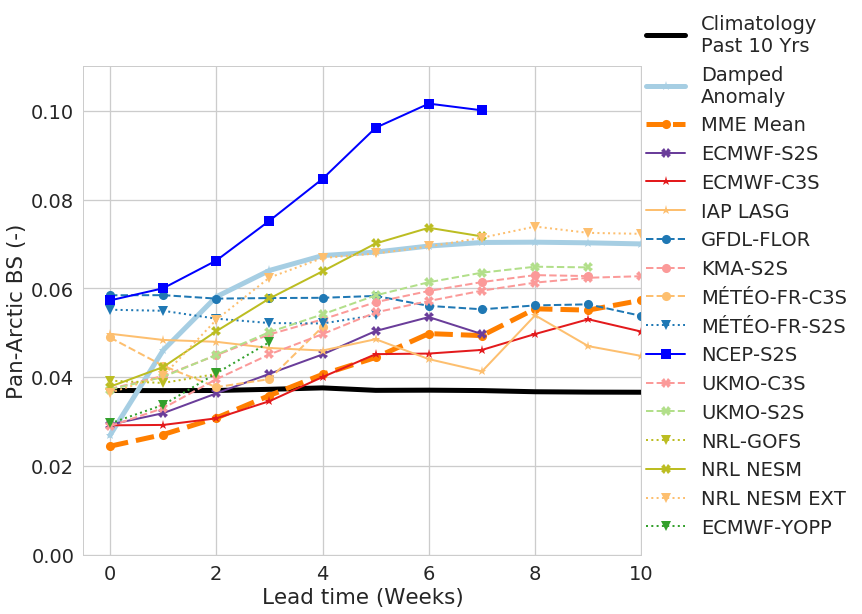

In [12]:
### Plot Brier Score vs lead time

min_N_samples = 10 # Min number of samples to allow for mean
BSS_agg_init = BSS_agg.mean(dim='init_end')
sns.set_style("whitegrid")

sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

# Get sample size of for each lead time
for_sample = BSS_agg.sel(model='MME').notnull().sum(dim='init_end')
for_sample

# Use threshold of sample size to cut off lead times
max_lead = for_sample.where(for_sample>=min_N_samples,drop=True).fore_time.max().values.astype('timedelta64[D]').astype(int)/7

f = plt.figure(figsize=(10,10))
NM = 10
ax1 = plt.subplot2grid((NM, NM), (0, 0), colspan=NM, rowspan=NM-1)

for cmod in model_plot_order:
#for cmod in ['climatology']:
    # Get model plotting specs
    cc = E.model_color[cmod]
    cl = E.model_linestyle[cmod]
    cm = E.model_marker[cmod]
    if cmod=='rasmesrl':
        cflag = '*'
    else:
        cflag = ''

    if cmod in ['MME','dampedAnomalyTrend','climatology','climo10yrs']:
        lw = 5
    else:
        lw = 2

    ax1.plot(BSS_agg_init.fore_time.values.astype('timedelta64[D]').astype(int)/7,
            BSS_agg_init.sel(model=cmod).values, label=E.model[cmod]['model_label'].rstrip('*')+cflag,
            color=cc,
            linestyle=cl,
            linewidth=lw,
            marker=cm)
    
ax1.legend(loc='lower right', bbox_to_anchor=(1.4, 0))
ax1.set_ylabel('Pan-Arctic BS (-)')
ax1.set_xlabel('Lead time (Weeks)')

ax1.set_ylim([0,0.11]);
ax1.set_xlim([-0.5,10]);
ax1.set_xticks(np.arange(0,11,2));

# Save to file
f_out = os.path.join(fig_dir,fig_ext+'BSS_by_lead_time_PanArctic.png')
f.savefig(f_out,bbox_inches='tight', dpi=300)
print('saving ',f_out)

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


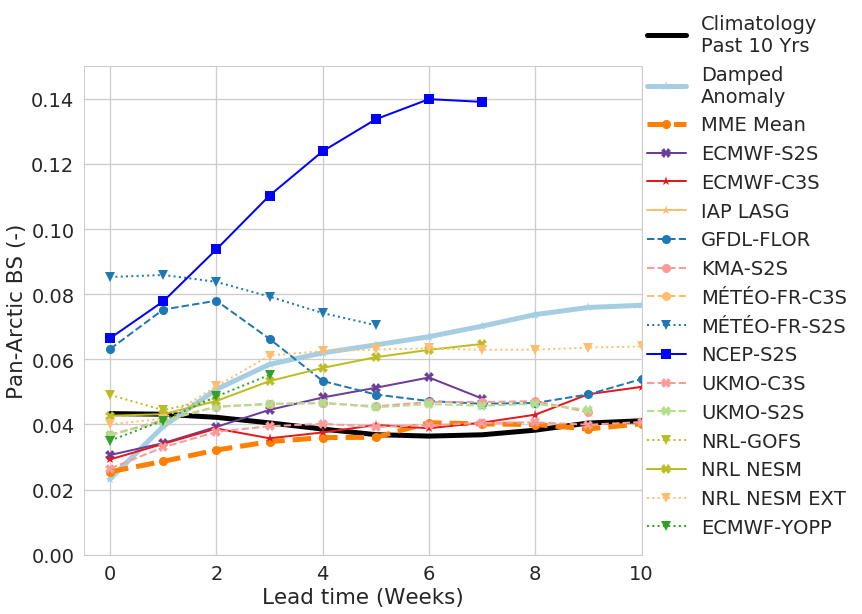

In [14]:
### Plot Brier Score vs lead time Summer Months
BSS_agg_init = BSS_agg.sel(init_end=slice('2018-06-06','2018-09-01')).mean(dim='init_end')
sns.set_style("whitegrid")

sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

# Get sample size of for each lead time
for_sample = BSS_agg.sel(model='MME').notnull().sum(dim='init_end')
for_sample

# Use threshold of sample size to cut off lead times
max_lead = for_sample.where(for_sample>=min_N_samples,drop=True).fore_time.max().values.astype('timedelta64[D]').astype(int)/7

f = plt.figure(figsize=(10,10))
NM = 10
ax1 = plt.subplot2grid((NM, NM), (0, 0), colspan=NM, rowspan=NM-1)

for cmod in model_plot_order:
#for cmod in ['climatology']:
    # Get model plotting specs
    cc = E.model_color[cmod]
    cl = E.model_linestyle[cmod]
    cm = E.model_marker[cmod]
    if cmod=='rasmesrl':
        cflag = '*'
    else:
        cflag = ''

    if cmod in ['MME','dampedAnomalyTrend','climatology','climo10yrs']:
        lw = 5
    else:
        lw = 2

    ax1.plot(BSS_agg_init.fore_time.values.astype('timedelta64[D]').astype(int)/7,
            BSS_agg_init.sel(model=cmod).values, label=E.model[cmod]['model_label'].rstrip('*')+cflag,
            color=cc,
            linestyle=cl,
            linewidth=lw,
            marker=cm)
    
ax1.legend(loc='lower right', bbox_to_anchor=(1.4, 0))
ax1.set_ylabel('Pan-Arctic BS (-)')
ax1.set_xlabel('Lead time (Weeks)')

ax1.set_ylim([0,0.15]);
ax1.set_xlim([-0.5,10]);
ax1.set_xticks(np.arange(0,11,2));

# Save to file
f_out = os.path.join(fig_dir,fig_ext+'BSS_JJAS_by_lead_time_PanArctic.png')
f.savefig(f_out,bbox_inches='tight', dpi=300)

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


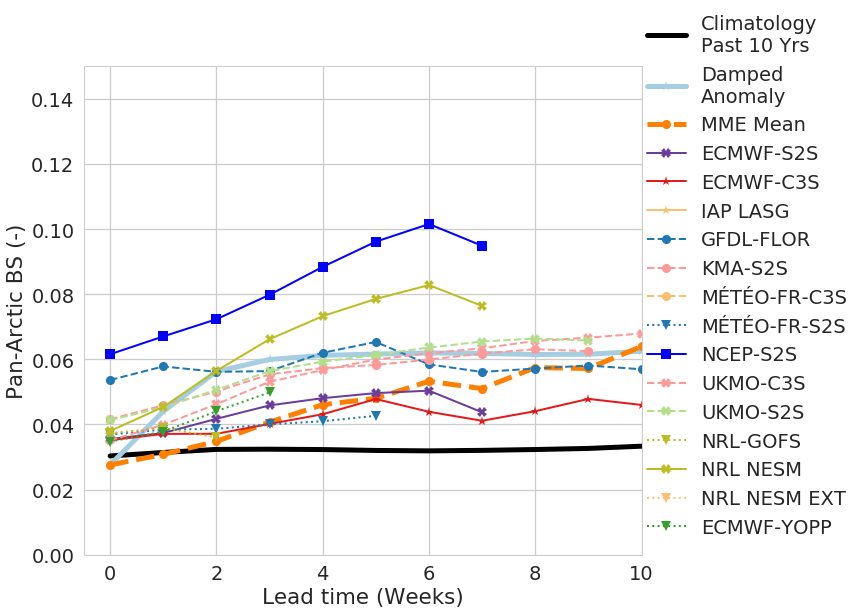

In [15]:
### Plot Brier Score vs lead time Winter Months
BSS_agg_init = BSS_agg.sel(init_end=slice('2018-11-06','2019-04-01')).mean(dim='init_end')
sns.set_style("whitegrid")

sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

# Get sample size of for each lead time
for_sample = BSS_agg.sel(model='MME').notnull().sum(dim='init_end')
for_sample

# Use threshold of sample size to cut off lead times
max_lead = for_sample.where(for_sample>=min_N_samples,drop=True).fore_time.max().values.astype('timedelta64[D]').astype(int)/7

f = plt.figure(figsize=(10,10))
NM = 10
ax1 = plt.subplot2grid((NM, NM), (0, 0), colspan=NM, rowspan=NM-1)

for cmod in model_plot_order:
    # Get model plotting specs
    cc = E.model_color[cmod]
    cl = E.model_linestyle[cmod]
    cm = E.model_marker[cmod]
    if cmod=='rasmesrl':
        cflag = '*'
    else:
        cflag = ''

    if cmod in ['MME','dampedAnomalyTrend','climatology','climo10yrs']:
        lw = 5
    else:
        lw = 2

    ax1.plot(BSS_agg_init.fore_time.values.astype('timedelta64[D]').astype(int)/7,
            BSS_agg_init.sel(model=cmod).values, label=E.model[cmod]['model_label'].rstrip('*')+cflag,
            color=cc,
            linestyle=cl,
            linewidth=lw,
            marker=cm)
    
ax1.legend(loc='lower right', bbox_to_anchor=(1.4, 0))
ax1.set_ylabel('Pan-Arctic BS (-)')
ax1.set_xlabel('Lead time (Weeks)')

ax1.set_ylim([0,0.15]);
ax1.set_xlim([-0.5,10]);
ax1.set_xticks(np.arange(0,11,2));

# Save to file
f_out = os.path.join(fig_dir,fig_ext+'BSS_NDJFM_by_lead_time_PanArctic.png')
f.savefig(f_out,bbox_inches='tight', dpi=300)

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


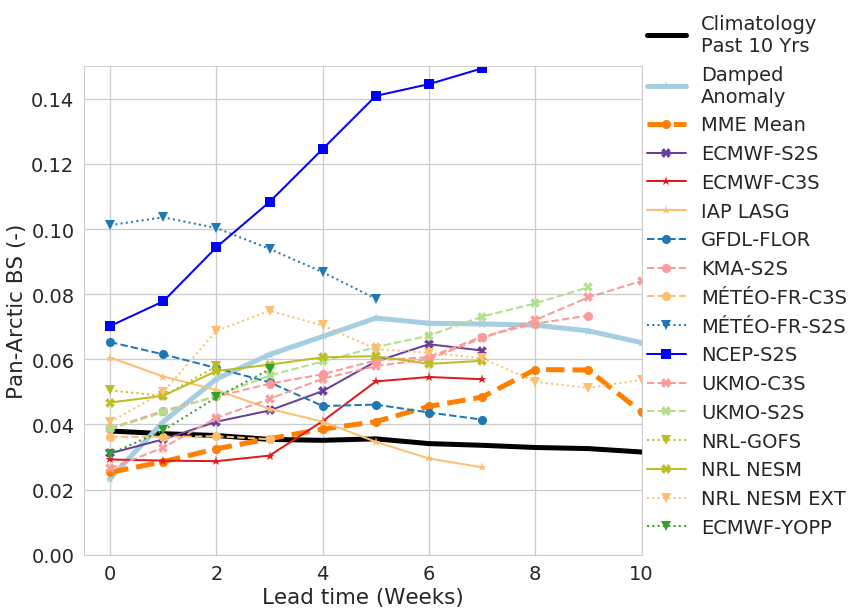

In [16]:
### Plot Brier Score vs lead time Summer Months
BSS_agg_init = BSS_agg.sel(init_end=slice('2019-06-06','2019-09-01')).mean(dim='init_end')
sns.set_style("whitegrid")

sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

# Get sample size of for each lead time
for_sample = BSS_agg.sel(model='MME').notnull().sum(dim='init_end')
for_sample

# Use threshold of sample size to cut off lead times
max_lead = for_sample.where(for_sample>=min_N_samples,drop=True).fore_time.max().values.astype('timedelta64[D]').astype(int)/7

f = plt.figure(figsize=(10,10))
NM = 10
ax1 = plt.subplot2grid((NM, NM), (0, 0), colspan=NM, rowspan=NM-1)

for cmod in model_plot_order:
    # Get model plotting specs
    cc = E.model_color[cmod]
    cl = E.model_linestyle[cmod]
    cm = E.model_marker[cmod]
    if cmod=='rasmesrl':
        cflag = '*'
    else:
        cflag = ''

    if cmod in ['MME','dampedAnomalyTrend','climatology','climo10yrs']:
        lw = 5
    else:
        lw = 2

    ax1.plot(BSS_agg_init.fore_time.values.astype('timedelta64[D]').astype(int)/7,
            BSS_agg_init.sel(model=cmod).values, label=E.model[cmod]['model_label'].rstrip('*')+cflag,
            color=cc,
            linestyle=cl,
            linewidth=lw,
            marker=cm)
    
ax1.legend(loc='lower right', bbox_to_anchor=(1.4, 0))
ax1.set_ylabel('Pan-Arctic BS (-)')
ax1.set_xlabel('Lead time (Weeks)')

ax1.set_ylim([0,0.15]);
ax1.set_xlim([-0.5,10]);
ax1.set_xticks(np.arange(0,11,2));

# Save to file
f_out = os.path.join(fig_dir,fig_ext+'BSS_2019JJAS_by_lead_time_PanArctic.png')
f.savefig(f_out,bbox_inches='tight', dpi=300)

In [17]:
SIP_IIEE.load()

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


<xarray.DataArray (model: 17, init_end: 99, fore_time: 52)>
array([[[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [1.577207, 1.536218, ...,      nan,      nan],
        [1.536218,      nan, ...,      nan,      nan]],

       [[0.264089, 0.952201, ..., 1.067448, 1.165981],
        [0.306052, 1.034895, ..., 1.165966, 0.961742],
        ...,
        [0.591892, 1.336634, ...,      nan,      nan],
        [0.507716,      nan, ...,      nan,      nan]],

       ...,

       [[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan]],

       [[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [0.466252, 0.599742, ...,      nan,      nan],
        [0.454364,      nan, ...,      nan, 

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


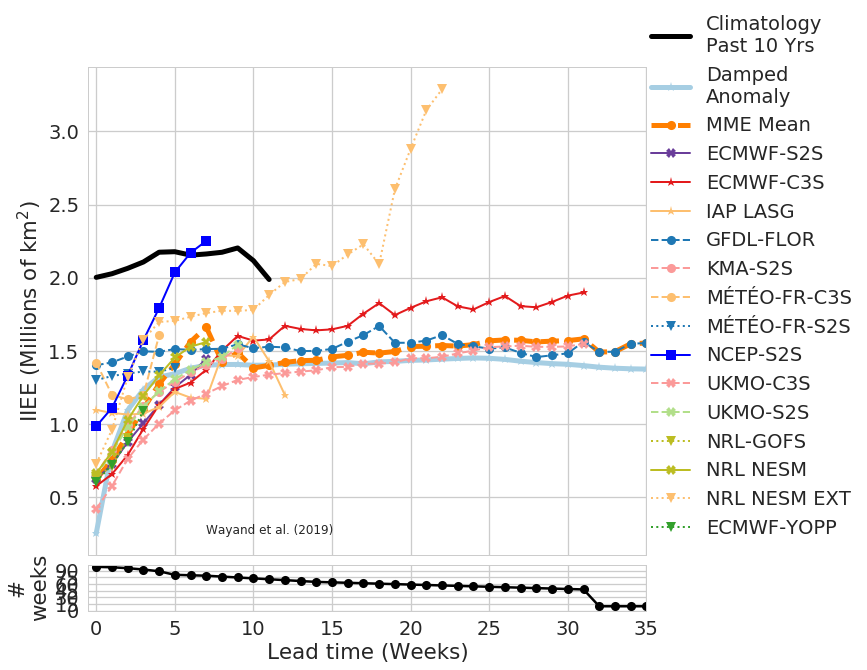

In [18]:
### Plot the IIEE with lead time (SI)

min_N_samples = 10 # Min number of samples to allow for mean
SIP_IIEE_init = SIP_IIEE.mean(dim='init_end')
sns.set_style("whitegrid")

sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

# Get sample size of for each lead time
for_sample = SIP_IIEE.sel(model='MME').notnull().sum(dim='init_end')

# Use threshold of sample size to cut off lead times
max_lead = for_sample.where(for_sample>=min_N_samples,drop=True).fore_time.max().values.astype('timedelta64[D]').astype(int)/7

f = plt.figure(figsize=(10,10))
NM = 10
ax1 = plt.subplot2grid((NM, NM), (0, 0), colspan=NM, rowspan=NM-1)
ax2 = plt.subplot2grid((NM, NM), (NM-1, 0), colspan=NM, rowspan=1)

for cmod in model_plot_order:
    # Get model plotting specs
    cc = E.model_color[cmod]
    cl = E.model_linestyle[cmod]
    cm = E.model_marker[cmod]
    if cmod=='rasmesrl':
        cflag = '*'
    else:
        cflag = ''
    if cmod in ['MME','dampedAnomalyTrend','climatology','climo10yrs']:
        lw=5
    else:
        lw = 2

    ax1.plot(SIP_IIEE_init.fore_time.values.astype('timedelta64[D]').astype(int)/7,
            SIP_IIEE_init.sel(model=cmod).values, label=E.model[cmod]['model_label'].rstrip('*')+cflag,
            color=cc,
            linestyle=cl,
            linewidth=lw,
            marker=cm)
ax1.legend(loc='lower right', bbox_to_anchor=(1.4, 0))
ax1.set_ylabel('IIEE (Millions of km$^2$)')
ax1.set_xlim([-0.5,max_lead])
ax1.set_xticklabels([''])

# second axis
ax2.plot(for_sample.fore_time.values.astype('timedelta64[D]').astype(int)/7,
         for_sample.values, '-ko')
ax2.set_ylabel('#\nweeks')
ax2.set_xlabel('Lead time (Weeks)')
ax2.set_xlim(ax1.get_xlim());

ax2.set_ylim([0,for_sample.max()+5]);
ax2.set_yticks(np.arange(0,for_sample.max()+5,15));

if not PaperPlots: # only add for website plots
#        ax1.text(np.datetime64('2018-01-01'), 0.025, 'Wayand et al. (in review)', fontsize=12)
    ax1.text(7, 0.25, 'Wayand et al. (2019)', fontsize=12)


# Save to file
f_out = os.path.join(fig_dir,fig_ext+'IIEE_by_lead_time_PanArctic.png')
f.savefig(f_out,bbox_inches='tight', dpi=200)

fgoalssipn not in dict
meteofrsipn not in dict


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


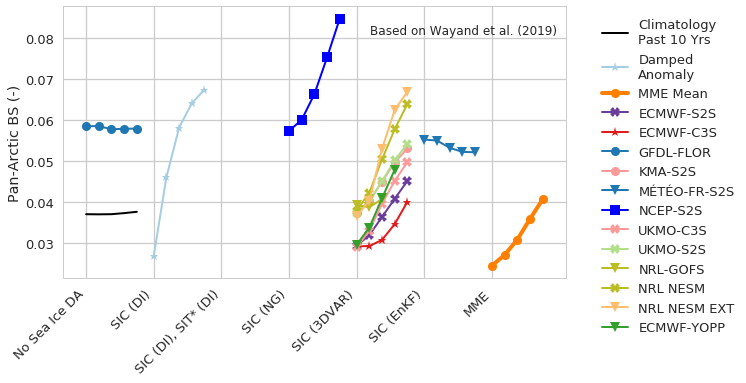

In [19]:
### Define DA methods for each model

# copy past info from Table 1
DA_dict = {
'modcansipns_3':'SIC (NG)', 
'modcansipns_4':'SIC (NG)',
'ecmwfsipn':'SIC (3DVAR)', 
'ecmwf':'SIC (3DVAR)',
'yopp':'SIC (3DVAR)',
'gfdlsipn':'No Sea Ice DA',
'metreofr':'SIC (EnKF)',
'szapirosipn':'No Sea Ice DA',
'ncep-exp-bias-corr':'SIC (NG)',
'noaasipn':'SIC (NG)',
'usnavysipn':'SIC (3DVAR)',
'usnavyncep':'SIC (3DVAR)',
'usnavygofs':'SIC (3DVAR)',
'rasmesrl':'SIC (DI), SIT* (DI)',
'uclsipn':'No Sea Ice DA',
'ukmetofficesipn':'SIC (3DVAR)',
'ukmo':'SIC (3DVAR)',
'ncep':'SIC (NG)',
'kma':'SIC (3DVAR)'
}

# Add models
DA_dict['climo10yrs'] = 'No Sea Ice DA'
DA_dict['dampedAnomalyTrend'] = 'SIC (DI)'
DA_dict['MME'] = 'MME'
DA_dict

DA_options = sorted(list(set(DA_dict.values())))
dict(zip(DA_options,np.arange(len(DA_options))))

#DA_options = [DA_options[1],  DA_options[4], DA_options[5], DA_options[7], DA_options[2], DA_options[3], DA_options[6],DA_options[0],] # Reorder from simple to complex
DA_options = [DA_options[1],  DA_options[3], DA_options[4], DA_options[6], DA_options[2], DA_options[5],DA_options[0],] # Reorder from simple to complex

DA_options_i = np.arange(len(DA_options))
DA_options_dict = dict(zip(DA_options,DA_options_i))
DA_options_dict

### Plot BS by DA method (Figure 4)

# In place a multi lead times

# Lead times to plot
leads2plot = [0,1,2,3,4] # indices
sns.set_style("whitegrid")

sns.set_context("talk", font_scale=1, rc={"lines.linewidth": 2.5})
f, axes = plt.subplots(1, 1, figsize=(9, 5))

for cmod in BSS_agg.model.values:
    if cmod in DA_dict.keys():
        # Get model plotting specs
        cc = E.model_color[cmod]
        cl = E.model_linestyle[cmod]
        cm = E.model_marker[cmod]
        if cmod=='MME':
            lw=4
        else:
            lw=2

        BSS_init = BSS_agg.sel(model=cmod).isel(fore_time=leads2plot).mean(dim='init_end').load()

        #rand_jit = np.random.randint(-100,100)/1000*2
        c_x = np.linspace(DA_options_dict[DA_dict[cmod]],
                          DA_options_dict[DA_dict[cmod]]+0.75,
                          len(leads2plot))
        #print(c_x)

        axes.plot(c_x, 
                BSS_init.values,
                color=cc,
                linestyle='-',
                linewidth=lw,
                marker=cm,
                label=E.model[cmod]['model_label'].rstrip('*'))
    else:
        print(cmod,"not in dict")
axes.set_xticks(DA_options_i)
axes.set_xticklabels(DA_options, rotation='45', ha='right')

plt.legend(loc='lower right', bbox_to_anchor=(1.36, -.25))
plt.ylabel('Pan-Arctic BS (-)')

if not PaperPlots: # only add for website plots
    axes.text(4.2, 0.081, 'Based on Wayand et al. (2019)', fontsize=12)

# Save to file
f_out = os.path.join(fig_dir,fig_ext+'BSS_week_Multi_by_DA_Type.png')
f.savefig(f_out,bbox_inches='tight', dpi=200)

Finished Eval_Weekly


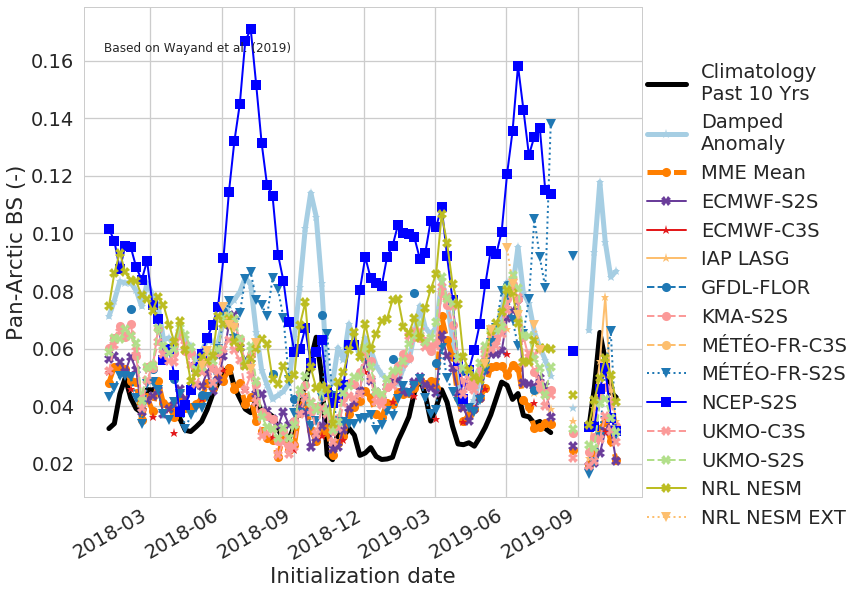

In [20]:
### Plot BS by initialization time (Figure 2)

sns.set_style("whitegrid")

for ft_i in [4]:
    BSS_agg_fore = BSS_agg.isel(fore_time=ft_i)

    sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})
    f = plt.figure(figsize=(10,10))
    for cmod in model_plot_order:
        # Get model plotting specs
        cc = E.model_color[cmod]
        cl = E.model_linestyle[cmod]
        cm = E.model_marker[cmod]
        if cmod in ['MME','dampedAnomalyTrend','climatology','climo10yrs']:
            lw=5
        else:
            lw = 2
        if BSS_agg_fore.sel(model=cmod).notnull().sum().values==0:
            continue # Don't plot
        plt.plot(BSS_agg_fore.init_end.values,
                BSS_agg_fore.sel(model=cmod).values, label=E.model[cmod]['model_label'].rstrip('*'),
                color=cc,
                linestyle=cl,
                linewidth=lw,
                marker=cm)
    plt.legend(loc='lower right', bbox_to_anchor=(1.4, -0.1))
    plt.ylabel('Pan-Arctic BS (-)')
    plt.xlabel('Initialization date')
    #plt.title(BSS_agg_fore.fore_time.values.astype('timedelta64[D]').astype(int))
    f.autofmt_xdate()


    if not PaperPlots: # only add for website plots
        plt.text(np.datetime64('2018-01-01'), 0.163, 'Based on Wayand et al. (2019)', fontsize=12)
    # Save to file
    f_out = os.path.join(fig_dir,fig_ext+'BSS_by_init_time_'+str(BSS_agg_fore.fore_time.values.astype('timedelta64[D]').astype(int))+'_days.png')
    f.savefig(f_out,bbox_inches='tight', dpi=200)

    print("Finished Eval_Weekly")

In [ ]:
if __name__ == '__main__':
    # Start up Client
    client = Client(n_workers=8)
    
    # Call function
    Update_Evaluation_Maps(PaperPlots)

In [29]:
BSS_agg_fore.init_end.values

array(['2018-01-07T00:00:00.000000000', '2018-01-14T00:00:00.000000000',
       '2018-01-21T00:00:00.000000000', '2018-01-28T00:00:00.000000000',
       '2018-02-04T00:00:00.000000000', '2018-02-11T00:00:00.000000000',
       '2018-02-18T00:00:00.000000000', '2018-02-25T00:00:00.000000000',
       '2018-03-04T00:00:00.000000000', '2018-03-11T00:00:00.000000000',
       '2018-03-18T00:00:00.000000000', '2018-03-25T00:00:00.000000000',
       '2018-04-01T00:00:00.000000000', '2018-04-08T00:00:00.000000000',
       '2018-04-15T00:00:00.000000000', '2018-04-22T00:00:00.000000000',
       '2018-04-29T00:00:00.000000000', '2018-05-06T00:00:00.000000000',
       '2018-05-13T00:00:00.000000000', '2018-05-20T00:00:00.000000000',
       '2018-05-27T00:00:00.000000000', '2018-06-03T00:00:00.000000000',
       '2018-06-10T00:00:00.000000000', '2018-06-17T00:00:00.000000000',
       '2018-06-24T00:00:00.000000000', '2018-07-01T00:00:00.000000000',
       '2018-07-08T00:00:00.000000000', '2018-07-15

In [30]:
ft_i=4
BSS_agg_fore = BSS_agg.isel(fore_time=ft_i)

cmod = 'climo10yrs'
print('First ',BSS_agg_fore.sel(model=cmod).values)

ft_i=3
BSS_agg_fore = BSS_agg.isel(fore_time=ft_i)

print('First ',BSS_agg_fore.sel(model=cmod).values)


cmod = 'ecmwf'
print('Second ',BSS_agg_fore.sel(model=cmod).values)

First  [0.03221268 0.03394058 0.04417481 0.04981289 0.04280932 0.03908865
 0.03774227 0.04572673 0.04559591 0.0466621  0.04033715 0.04029868
 0.0364016  0.03574388 0.03161284 0.03117416 0.032842   0.03470781
 0.03876758 0.04402135 0.04798264 0.05140585 0.05377733 0.04664109
 0.04271355 0.0389668  0.03772298 0.04220219 0.03804504 0.03789678
 0.03641911 0.03255975 0.02755724 0.02862515 0.03309564 0.04138125
 0.04756059 0.05604039 0.0639238  0.05061945 0.02319524 0.02139289
 0.03177706 0.02922155 0.03231892 0.02992875 0.0228948  0.02372428
 0.02560579 0.02251863 0.02146745 0.02164492 0.02223609 0.02798646
 0.03202284 0.03631445 0.04472026 0.04966337 0.04389234 0.03479782
 0.03958033 0.04569053 0.04135259 0.03298435 0.02685824 0.02660364
 0.02728066 0.02608853 0.02914213 0.03264957 0.03697207 0.04262048
 0.04835327 0.04720674 0.04234306 0.04436932 0.03674466 0.03628312
 0.03395708 0.03468782 0.03227344 0.03081559        nan        nan
        nan 0.02474786        nan        nan 0.03256416

In [ ]:
for cmod in model_plot_order:
    # Get model plotting specs
    cc = E.model_color[cmod]
    cl = E.model_linestyle[cmod]
    cm = E.model_marker[cmod]
    if cmod in ['MME','dampedAnomalyTrend','climatology','climo10yrs']:
        lw=5
    else:
        lw = 2
    if BSS_agg_fore.sel(model=cmod).notnull().sum().values==0:
        continue # Don't plot
    plt.plot(BSS_agg_fore.init_end.values,
            BSS_agg_fore.sel(model=cmod).values, label=E.model[cmod]['model_label'].rstrip('*'),
            color=cc,
            linestyle=cl,
            linewidth=lw,
            marker=cm)
plt.legend(loc='lower right', bbox_to_anchor=(1.4, -0.1))
plt.ylabel('Pan-Arctic BS (-)')
plt.xlabel('Initialization date')
#plt.title(BSS_agg_fore.fore_time.values.astype('timedelta64[D]').astype(int))
f.autofmt_xdate()